<a href="https://colab.research.google.com/github/heber-augusto/weather-forecast/blob/master/weather_forecast_using_iot_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wheather forecast using iot data
The goal from this project is to evaluate how temperature and humidity sensors from a datacenter is good for predicting rain precipitation.

This notebook demonstrates some important steps in real data science projects and is divided in the folowwing parts:

 1. Collecting the data;
 2. Preparing the data;
 3. Feature Engineering and analysis;
 4. Model training;
 5. Results.



In [299]:
import pandas as pd
import numpy as np

from pandas.tseries.offsets import MonthEnd

import requests
import base64
import json
from getpass import getpass
from datetime import datetime, timedelta

import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns



# Collecting the data
The data collection is divided in:
1. Obtaining a token from the REST API;
2. Using the token to obtain data;
3. Creating a dataframe with all the data.

## 1.Obtaining a token from the REST API;

In [ ]:
# get user and password without showing
base  = "https://api.telemetria.hitecnologia.com.br/rest/v1/"
user = getpass('Enter the user name: ')
pwd  = getpass('Enter the secret value: ')

Enter the user name: ··········
Enter the secret value: ··········


In [ ]:
# encode password into base64
p=base64.b64encode(pwd.encode())
pwd=p.decode()
url='{}/auth/login/'.format(base)
headers={
    "Content-Type": "application/json", 
    "Accept": "application/json"
}
data={
    "email":"{}".format(user),
    "password":"{}".format(pwd)
}

# request token
response = requests.post(
    url=url,
    data=json.dumps(data), 
    headers=headers
)
result = json.loads(response.text)

In [ ]:
access_token = result["token"]

## 2.Using the token to obtain data for each month;

This process is divided in:

1. mounting lists with start and end from each 30 days interval;
2. getting values for each 30 days.

This is needed because the REST api limits the results from history endpoint in a 30 days interval.

### Monting lists with start and end from each 30 days

In [72]:
start_dates = pd.date_range('2017-01-01',datetime.now().strftime("%Y-%b"), 
              freq='30D').strftime("%Y-%m-%dT00:00:00-03:00").to_list()

end_dates = (pd.date_range('2017-01-30',datetime.now().strftime("%Y-%b"), 
              freq='30D')).strftime("%Y-%m-%dT23:59:59-03:00").to_list()

if len(start_dates) > len(end_dates):
    end_dates.append(datetime.now().strftime("%Y-%m-%dT23:59:59-03:00"))

  

### Getting values for each 30 days.

In [73]:
all_months_list = []
for index, start in enumerate(start_dates):
    end = end_dates[index]
    # format url to call rest api
    data_ids = '128,129'
    history_url = f'{base}data_history/?format=json&data_ids={data_ids}&start={start}&end={end}'

    header={
        "Content-Type": "application/json", 
        "Accept": "application/json",
        "Authorization":"Bearer {0}".format(access_token),
    }

    # get temperature and humidity sensor values from last 30 days
    response = requests.get(history_url, headers=header)
    all_months_list.append(pd.read_json(response.text))


## Creating a dataframe with all the data.

In [76]:
concat_result = pd.concat(all_months_list, axis = 0)
concat_result.to_csv('sensors.csv')

# Preparing the data
The Preparing the data is divided in:

1. Grouping data by data id to separate data into columns;
2. Resampling 1 hour considering the mean;
3. Creating the dataset with temperature and humidity mean for each hour;
4. Creating one line for each date and one column for each hour;
5. Putting it together with the output.


## Grouping data by data id to separate data into columns
This is necessary because the data is returned with only 3 columns: data_id, value and datetime

In [78]:
# use the following line if you don´t want to collect data 
#concat_result = pd.read_csv('sensors.csv')

grouped = concat_result.groupby('data_id')


## Resampling 1 hour considering the mean
Consider the mean value and resample to 1 hour

In [81]:
temp_group = grouped.get_group(128)
temp_group = temp_group.rename(columns={"value": "temperature"})
temp_group.index = temp_group['date_time']
temp_group = temp_group[['temperature']]
temp_group = temp_group.resample('1H').mean()

humi_group = grouped.get_group(129)
humi_group = humi_group.rename(columns={"value": "humidity"})
humi_group.index = humi_group['date_time']
humi_group = humi_group[['humidity']]
humi_group = humi_group.resample('1H').mean()

## Creating the dataset with temperature and humidity mean for each hour

Concatenate considering axis = 1 in order to create two columns

In [82]:
dataset = pd.concat([temp_group, humi_group], axis = 1)

## Creating one line for each date and one column for each hour
This is divided in:
1. Create two new columns (hour and date);
2. Group the dataframe by date;
3. Create columns for each hour;
4. Rename columns and create the final dataset.

### Create two new columns (hour and date)

In [116]:
dataset['hour'] = dataset.index.hour
dataset['date']  = dataset.index.date

### Group the dataframe by date

In [146]:
df = dataset.groupby(['date',])

### Create columns for each hour

In [150]:
columns_df = df['temperature','humidity'].apply(
    lambda df: df.reset_index(drop=True)).unstack()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


### Rename columns and create the final dataset

In [151]:
columns = [f'temperature_{hour}' for hour in range(24)] + \
  [f'humidity_{hour}' for hour in range(24)]
final_df = pd.DataFrame(columns_df.values,index=columns_df.index, columns=columns)

## Putting it together with the output.

In [287]:
# some useful options were used here:
# 1. skip the first 8 lines (containing header);
# 2. ; as column separator;
# 3. , as decimal separator.

agritempo = pd.read_csv(
    'agritempo.csv',
    sep=';',
    skiprows=8,
    decimal=",",
    skipinitialspace=True)

# remove white spaces from column names
agritempo = agritempo.rename(columns=lambda x: x.strip())
agritempo.index = pd.to_datetime(agritempo['data'], format='%d/%m/%Y')
output = agritempo[['precipitacao']]
output.index.name = 'date'

In [289]:
dataset  = pd.concat([final_df, output.sort_index()], axis=1)
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d')
dataset.loc[:,'precipitacao_next'] = dataset['precipitacao'].shift(-1)
dataset['target'] = 0
dataset.loc[dataset['precipitacao_next'] > 0, ['target']] = 1

# Feature Engineering
Some simple operations here:
1. Calculate daily mean for temperature and humidity;
2. Set mean daily value into nan temperature and humidity values;
3. Create 'quarter','month','year','weekday' for each date;
4. Drop date column and rows with nan values.

In [290]:
#check number of nan values 
dataset.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1359 entries, 2017-01-01 to 2020-09-20
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_0      1324 non-null   float64
 1   temperature_1      1323 non-null   float64
 2   temperature_2      1322 non-null   float64
 3   temperature_3      1321 non-null   float64
 4   temperature_4      1320 non-null   float64
 5   temperature_5      1322 non-null   float64
 6   temperature_6      1323 non-null   float64
 7   temperature_7      1324 non-null   float64
 8   temperature_8      1323 non-null   float64
 9   temperature_9      1322 non-null   float64
 10  temperature_10     1321 non-null   float64
 11  temperature_11     1323 non-null   float64
 12  temperature_12     1325 non-null   float64
 13  temperature_13     1327 non-null   float64
 14  temperature_14     1329 non-null   float64
 15  temperature_15     1327 non-null   float64
 16  temper

## Calculate daily mean for temperature and humidity

In [291]:
temp_columns = [col for col in dataset.columns if 'temperature' in col]
dataset['temp_mean'] = dataset[temp_columns].mean(axis=1)

humi_columns = [col for col in dataset.columns if 'humidity' in col]
dataset['humi_mean'] = dataset[humi_columns].mean(axis=1)


## Set mean daily value into nan temperature and humidity values

In [292]:
for column in temp_columns:
    dataset[column] = dataset[column].fillna(dataset['temp_mean'])
for column in humi_columns:
    dataset[column] = dataset[column].fillna(dataset['humi_mean'])


In [293]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1359 entries, 2017-01-01 to 2020-09-20
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_0      1337 non-null   float64
 1   temperature_1      1337 non-null   float64
 2   temperature_2      1337 non-null   float64
 3   temperature_3      1337 non-null   float64
 4   temperature_4      1337 non-null   float64
 5   temperature_5      1337 non-null   float64
 6   temperature_6      1337 non-null   float64
 7   temperature_7      1337 non-null   float64
 8   temperature_8      1337 non-null   float64
 9   temperature_9      1337 non-null   float64
 10  temperature_10     1337 non-null   float64
 11  temperature_11     1337 non-null   float64
 12  temperature_12     1337 non-null   float64
 13  temperature_13     1337 non-null   float64
 14  temperature_14     1337 non-null   float64
 15  temperature_15     1337 non-null   float64
 16  temper

## Create 'quarter','month','year','weekday' for each date

In [294]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekday'] = df['date'].dt.weekday    
    X = df[['quarter','month','year','weekday']]
    return X

# create new column to add
dataset['date'] = dataset.index
create_features(dataset)


,quarter,month,year,weekday
date,,,,
2017-01-01,1,1,2017,6
2017-01-02,1,1,2017,0
2017-01-03,1,1,2017,1
2017-01-04,1,1,2017,2
2017-01-05,1,1,2017,3
...,...,...,...,...
2020-09-16,3,9,2020,2
2020-09-17,3,9,2020,3
2020-09-18,3,9,2020,4


## Drop date column and rows with nan values

In [295]:
dataset=dataset.drop('date', axis=1).dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319 entries, 2017-01-01 to 2020-09-02
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_0      1319 non-null   float64
 1   temperature_1      1319 non-null   float64
 2   temperature_2      1319 non-null   float64
 3   temperature_3      1319 non-null   float64
 4   temperature_4      1319 non-null   float64
 5   temperature_5      1319 non-null   float64
 6   temperature_6      1319 non-null   float64
 7   temperature_7      1319 non-null   float64
 8   temperature_8      1319 non-null   float64
 9   temperature_9      1319 non-null   float64
 10  temperature_10     1319 non-null   float64
 11  temperature_11     1319 non-null   float64
 12  temperature_12     1319 non-null   float64
 13  temperature_13     1319 non-null   float64
 14  temperature_14     1319 non-null   float64
 15  temperature_15     1319 non-null   float64
 16  temper

## Correlation analisys

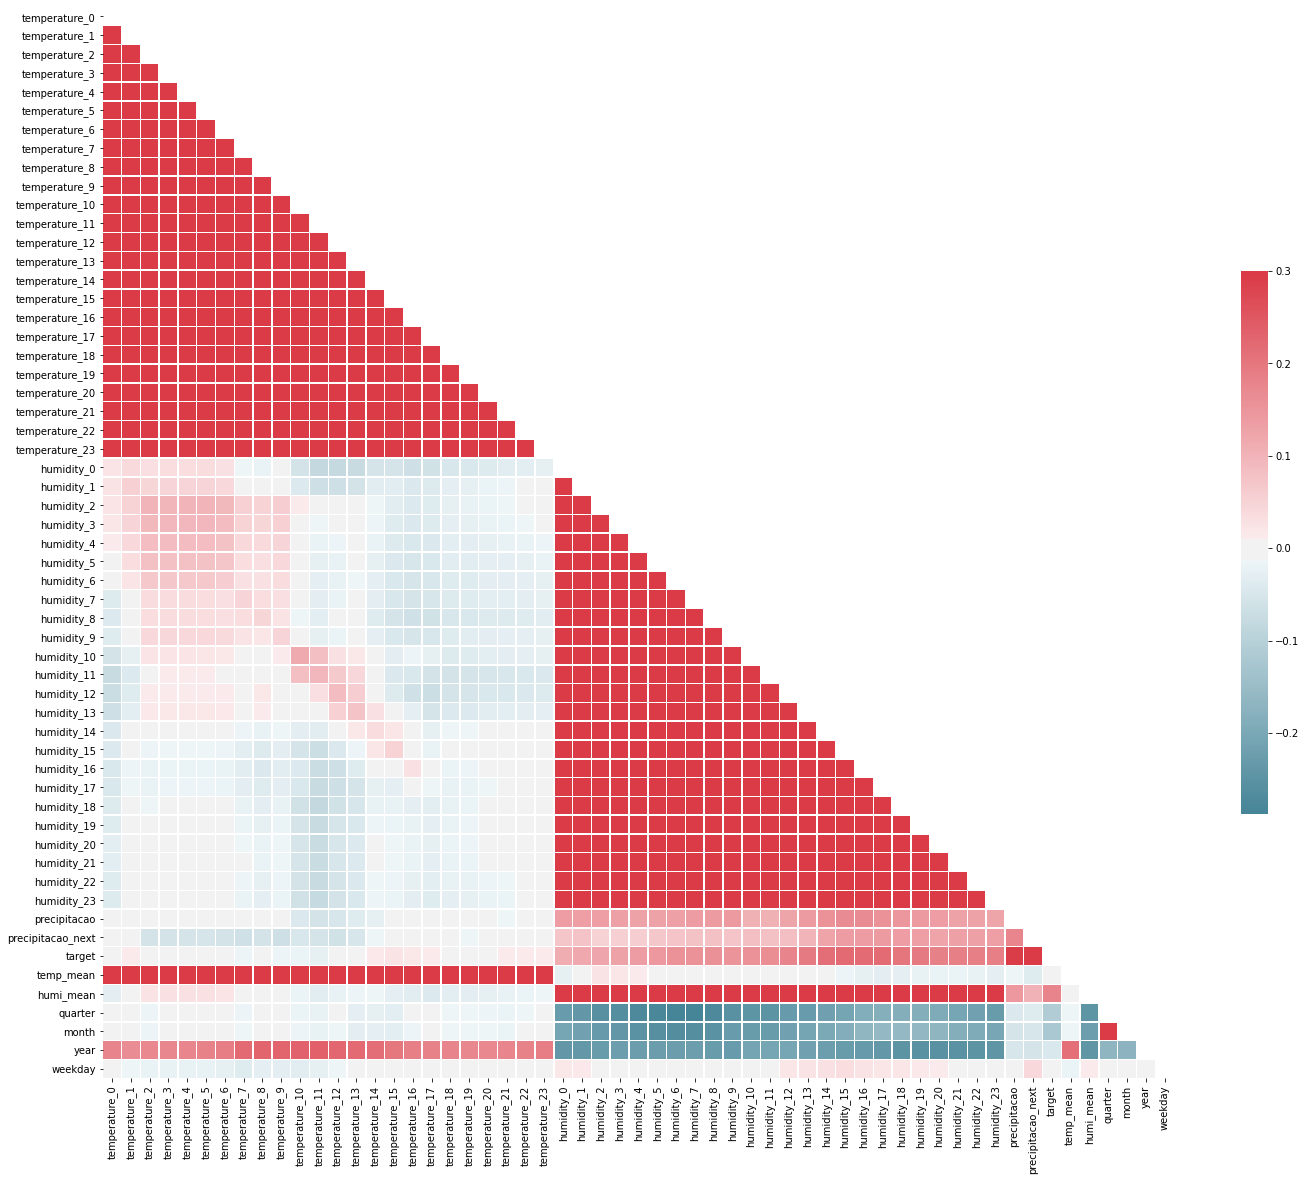

In [296]:
corr_columns = dataset.columns

# Compute the correlation matrix
corr = dataset[corr_columns].select_dtypes(include=[np.number]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(24, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Model training
The dataset was splited between before 2020 (train) and 2020 (test)

At this moment, the test was made with RandomForestClassifier()

In [297]:
dataset_train = dataset[dataset.year < 2020]
dataset_test  = dataset[dataset.year >= 2020]

# Labels are the values we want to predict
train_labels = np.array(dataset_train['target'])
test_labels = np.array(dataset_test['target'])

# Remove the labels from the features
# axis 1 refers to the columns
train_features= dataset_train.drop(['target','precipitacao_next'], axis = 1)
test_features= dataset_test.drop(['target','precipitacao_next'], axis = 1)

# Saving feature names for later use
feature_list = list(train_features.columns)

In [298]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1085, 55)
Training Labels Shape: (1085,)
Testing Features Shape: (234, 55)
Testing Labels Shape: (234,)


In [300]:
# Instantiate model 
rf = RandomForestClassifier(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Results:
The result accuracy was 81% which is really good without hypeparameters tunning and other models tests.

The confusion matrix tells that more than 96% of the sunny days were identified with success and 37% of the rainy days were predicted with success.

Considering that this result is just a start I think my conclusion is that I beat the "heads or tails"

In [301]:
y_pred=rf.predict(test_features)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.8162393162393162


In [302]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, y_pred)

array([[169,   7],
       [ 36,  22]])